# **1. PERKENALAN**

======================================================================================================================================================================================================================================
# <center>Phase 1: Live Code 4</center>


### <center>Nama  : Catherine Helenna Mulyadi</center>
### <center>Batch : RMT-027</center>


Tujuan dari program ini adalah membuat model regresi linear untuk memprediksi biaya yang harus dibayar pelajar jika ingin studi ke Inggris menggunakan dataset yang disediakan. Di dalam dataset, terdapat beberapa informasi berkaitan dengan profil universitas serta tuntutan pelajar untuk bersekolah di universitas tersebut. 

Informasi tentang universitas meliputi lokasi daerah dan umum, kapan universitas dibangun, ranking di UK dan dunia, persentase pelajar internasional, jumlah pelajar yang ada di universitas, jumlah staf akademik, tingkat kepuasan pelajar, dan tipe universitas. 

Sedangkan, tuntutan yang harus dipenuhi pelajar untuk memasuki universitas tersebut meliputi nilai minimum IELTS dan tuition fee.


======================================================================================================================================================================================================================================

# 2. **IMPORT LIBRARIES**

In [1]:
# berkaitan dengan EDA 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# berkaitan dengan feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# berkaitan dengan pemodelan
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# berkaitan dengan penyimpanan model
import pickle, joblib
import json

# 3.**DATA LOADING**

In [38]:
main_data = pd.read_csv("university-tuition-fees.csv")

# menunjukkan 5 data teratas
main_data.head()

,region,founded_year,uk_rank,world_rank,minimum_ielts_score,tuition_fees,international_students,student_satisfaction,student_enrollment,academic_staff,type,location,cost_of_living
0,Wales,1920,31,422,4.5,13800,15.4,81.5,"20,000-24,999","1,000-1,499",Public,Suburban,7500
1,London,1907,4,8,6.5,23500,41.4,77.9,"15,000-19,999","4,000-4,499",Public,Urban,10700
2,Wales,2011,112,1821,4.5,10800,18.0,80.0,"10,000-14,999",700-799,Public,Urban,7500
3,South West England,2001,95,2073,4.5,11500,3.7,78.0,"8,000-8,999",600-699,Public,Suburban,8217
4,East of England,1858,120,730,4.0,10500,10.4,79.0,"20,000-24,999",900-999,Public,Urban,9415


In [39]:
# mengecek informasi berkaitan tipe data tiap kolom

main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   region                  131 non-null    object 
 1   founded_year            131 non-null    int64  
 2   uk_rank                 131 non-null    int64  
 3   world_rank              131 non-null    int64  
 4   minimum_ielts_score     131 non-null    float64
 5   tuition_fees            131 non-null    int64  
 6   international_students  131 non-null    float64
 7   student_satisfaction    131 non-null    float64
 8   student_enrollment      131 non-null    object 
 9   academic_staff          131 non-null    object 
 10  type                    131 non-null    object 
 11  location                113 non-null    object 
 12  cost_of_living          131 non-null    int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 13.4+ KB


In [40]:
# cek data unik dari kolom location

main_data['location'].unique()

array(['Suburban', 'Urban', 'Rural', nan], dtype=object)

In [41]:
# membuat kolom baru menjumlahkan biaya yang harus dibayar yaitu tuition_fees + cost_of_living

main_data['total_cost'] = main_data['tuition_fees'] + main_data['cost_of_living']

main_data.head()

,region,founded_year,uk_rank,world_rank,minimum_ielts_score,tuition_fees,international_students,student_satisfaction,student_enrollment,academic_staff,type,location,cost_of_living,total_cost
0,Wales,1920,31,422,4.5,13800,15.4,81.5,"20,000-24,999","1,000-1,499",Public,Suburban,7500,21300
1,London,1907,4,8,6.5,23500,41.4,77.9,"15,000-19,999","4,000-4,499",Public,Urban,10700,34200
2,Wales,2011,112,1821,4.5,10800,18.0,80.0,"10,000-14,999",700-799,Public,Urban,7500,18300
3,South West England,2001,95,2073,4.5,11500,3.7,78.0,"8,000-8,999",600-699,Public,Suburban,8217,19717
4,East of England,1858,120,730,4.0,10500,10.4,79.0,"20,000-24,999",900-999,Public,Urban,9415,19915


### **INSIGHT:**
- Ditemukan terdapat 131 data dengan 13 kolom di dalam dataset yang digunakan.
- Khusus untuk kolom location, ternyata ditemukan ada 113 data non-null; artinya ada NaN values.
- Karena persentase jumlah data yang hilang cukup signifikan, sebaiknya data dengan nan values pada kolom location tidak dihapus.

# 4. **EXPLORATORY DATA ANALYSIS (EDA)**

### **PLOTTING JUMLAH UNIVERSITAS MENURUT GRUP LIGANYA:**

Kriteria liga:

- League A : world_rank < 99

- League B : 100 ≤ world_rank < 499

- League C : 500 ≤ world_rank < 999

- League D : 1000 ≤ world_rank < 1999

- League E : 2000 ≤ world_rank < 3999

- League F : world_rank ≥ 4000

In [68]:
# membuat copy untuk dataframe utama
main_data2 = main_data.copy()

# membuat kolom baru bernama league untuk pengelompokan liga berdasarkan world_rank
main_data2['League'] = np.where(main_data['world_rank']< 99,'League A',
                                np.where(main_data['world_rank']< 499, 'League B',
                                np.where(main_data['world_rank']< 999, 'League C',
                                np.where(main_data['world_rank']< 1999, 'League D',
                                np.where(main_data['world_rank']< 3999, 'League E',                  
                                'League F')))))               
main_data2

,region,founded_year,uk_rank,world_rank,minimum_ielts_score,tuition_fees,international_students,student_satisfaction,student_enrollment,academic_staff,type,location,cost_of_living,total_cost,League
0,Wales,1920,31,422,4.5,13800,15.4,81.5,"20,000-24,999","1,000-1,499",Public,Suburban,7500,21300,League B
1,London,1907,4,8,6.5,23500,41.4,77.9,"15,000-19,999","4,000-4,499",Public,Urban,10700,34200,League A
2,Wales,2011,112,1821,4.5,10800,18.0,80.0,"10,000-14,999",700-799,Public,Urban,7500,18300,League D
3,South West England,2001,95,2073,4.5,11500,3.7,78.0,"8,000-8,999",600-699,Public,Suburban,8217,19717,League E
4,East of England,1858,120,730,4.0,10500,10.4,79.0,"20,000-24,999",900-999,Public,Urban,9415,19915,League C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Yorkshire and the Humber,1954,77,734,4.5,12300,9.6,77.1,"15,000-19,999","1,000-1,499",Public,Suburban,8000,20300,League C
127,South West England,1975,110,1334,4.5,11300,7.4,72.2,"7,000-7,999",600-699,Public,Rural,8217,19517,League D
128,South East England,1966,32,342,5.5,13300,24.4,78.2,"15,000-19,999","1,000-1,499",Public,Suburban,10700,24000,League B
129,East Midlands,1957,41,167,4.5,14000,22.2,78.0,"15,000-19,999","1,500-1,999",Public,Suburban,7650,21650,League B


In [71]:
# grouping data dan dibuat dalam dataframe

data_liga = pd.DataFrame(main_data2.groupby('League')['League'].value_counts())

data_liga

,count
League,
League A,16
League B,32
League C,33
League D,23
League E,21
League F,6


In [76]:
# Data yang akan dipakai untuk plot
data_liga_sorted= data_liga.sort_values(by='count', ascending = False).reset_index()

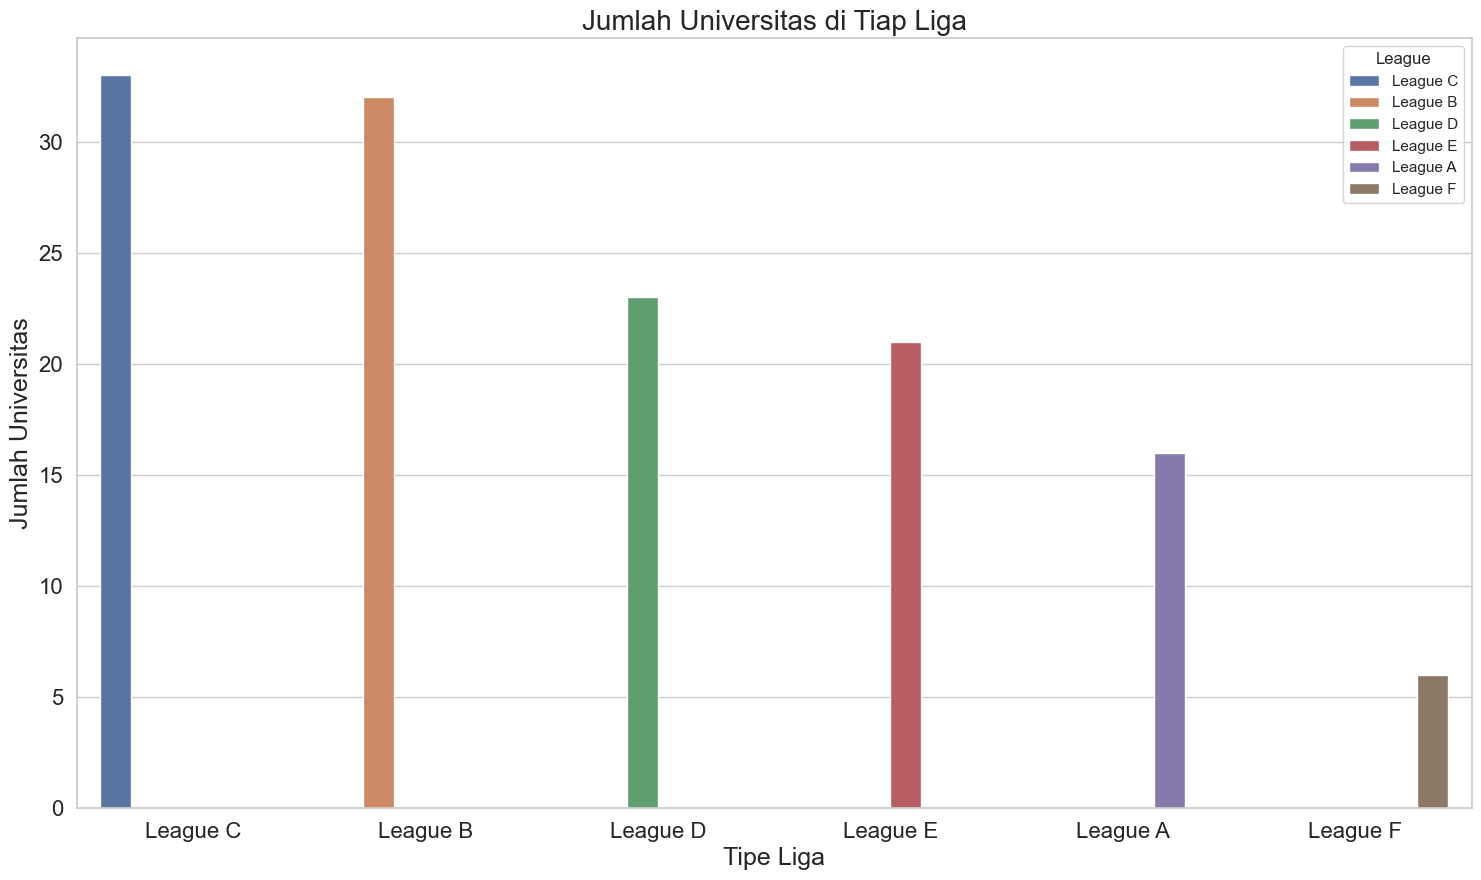

In [80]:
# Set bentuk plottinga
sns.set(style="whitegrid")

# Set ukuran figure
plt.figure(figsize=(18, 10))

# Plot bar graph untuk jenis liga
ax = sns.barplot(x='League', y='count', hue='League', data=data_liga_sorted)

# Set font size for axis labels
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Labelling the graph
plt.title('Jumlah Universitas di Tiap Liga', fontsize = 20)
plt.xlabel('Tipe Liga', fontsize = 18)
plt.ylabel('Jumlah Universitas', fontsize = 18)

# Show final plot
plt.show()

#### **INSIGHT:**
- Berdasarkan hasil grouping dan visualisasi dengan bar chart, ditemukan bahwa liga dengan jumlah universitas terbanyak adalah League C pada 33 universitas, diikuti League B pada 32 universitas, League D di 23 universitas, League E di 21 universitas, dan League F di 6 universitas.

### **MENINVESTIGASI HUBUNGAN ANTARA WORLD RANK, TIPE UNIVERSITAS, DAN TUITION FEES:**
- metode: ANOVA TEST

- Definisi hipotesis null (H0) dan hipotesis alternatif (H1):

    - H0 : Tidak ada hubungan signifikan antara ketiga variabel.

    - H1: Ada hubungan signifikan antara ketiga variabel.

- bila p-value < 0.05 maka H0 akan ditolak dan H1 akan diterima.

In [83]:
main_data['type'].unique()

array(['Public', 'Private'], dtype=object)

In [97]:
# karena tipe universitas tipe datanya kateogrik, maka perlu dikonversi supaya bisa dihitung oleh anova test

main_data3  = main_data.apply(lambda x: x.replace({'Public':'0', 'Private':'1'}, regex=True))

main_data3['type'] = main_data3['type'].astype(int)

# tipe data untuk type berhasil dikonversi menjadi integer (1 atau 0)
main_data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   region                  131 non-null    object 
 1   founded_year            131 non-null    int64  
 2   uk_rank                 131 non-null    int64  
 3   world_rank              131 non-null    int64  
 4   minimum_ielts_score     131 non-null    float64
 5   tuition_fees            131 non-null    int64  
 6   international_students  131 non-null    float64
 7   student_satisfaction    131 non-null    float64
 8   student_enrollment      131 non-null    object 
 9   academic_staff          131 non-null    object 
 10  type                    131 non-null    int64  
 11  location                113 non-null    object 
 12  cost_of_living          131 non-null    int64  
 13  total_cost              131 non-null    int64  
dtypes: float64(3), int64(7), object(4)
memory 

In [98]:
# syntax penghitungan
res = stats.f_oneway(main_data['world_rank'], main_data3['type'], main_data['tuition_fees'])
print('P-value:',res.pvalue)

P-value: 1.839634471361231e-220


#### **INSIGHT:**
- Berdasarkan hasil ANOVA TEST, ditemukan bahwa hipotesis null ditolak karena nilai p-value jauh lebih kecil dari 0.05. Artinya, ada hubungan signifikan antara tiga variabel ini.

### **SPLITING KOLOM DATA NUMERIK DAN KATEGORIK:**
- Tujuan: Supaya lebih mudah untuk proses penghitungan VIF value dan encoding.

In [108]:
# mendapatkan nama kolom data numerik dan kategorik

kolom_numerik = main_data.select_dtypes(include=np.number).columns.tolist()
kolom_kategorik = main_data.select_dtypes(include=['object']).columns.tolist()

print('Kolom-kolom berdata numerik: ', kolom_numerik)
print('Kolom-kolom berdata numerik: ', kolom_kategorik)

Kolom-kolom berdata numerik:  ['founded_year', 'uk_rank', 'world_rank', 'minimum_ielts_score', 'tuition_fees', 'international_students', 'student_satisfaction', 'cost_of_living', 'total_cost']
Kolom-kolom berdata numerik:  ['region', 'student_enrollment', 'academic_staff', 'type', 'location']


In [109]:
# buat dataframe terpisah untuk tipe data masing-masing

data_numerik = pd.DataFrame(main_data[kolom_numerik])

data_kategorik = pd.DataFrame(main_data[kolom_kategorik])

### **SCATTER PLOT DAN LINEAR TEST**
- Tujuan: Pemenuhan Asumsi 1 => Hubungan linear antara fitur dan target.

### <u>ASUMSI PERTAMA: HUBUNGAN LINEAR</u>
syarat : terlihat ada hubungan linear antara kolom lain dengan total cost dan lulus Pearson Test

In [44]:
# buatlah fungsi untuk scatter plot bagi data yang numerik
def scatters(data,y):
    cols = data.columns.tolist()
    for i in range (len(cols)):
        x_coor = data[cols[i]]
        y_coor = y
        plt.scatter(x_coor,y_coor)
        plt.xlabel(f'{cols[i]}')
        plt.ylabel('')
        # show data
        plt.show()

In [33]:
# buatlah fungsi untuk melihat hubungan linear antara data numerik dengan target = total cost
def linear_test(X,y):
    # memastikan tidak ada kolom price di dataset
    cols = X.columns.tolist()
    y = y
    keeper = []
    for i in range (len(cols)):
        corr_r, pval_p = stats.pearsonr(X[cols[i]], y)
        # kondisi di mana ada linear relationship (koefisien bukan 0 serta p value < 0.05)
        if corr_r !=0 and pval_p < 0.05:
            keeper.append(cols[i])
        else:
            pass
    # Menggunakan join untuk menyambungkan value dari satu indeks ke indeks lainnya
    print(f'There are {len(keeper)} variables which are linearly related based on Pearson testing result.')
    print(', '.join(map(str, keeper)))

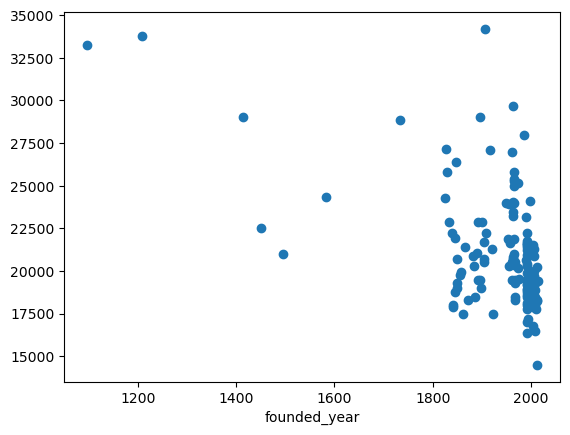

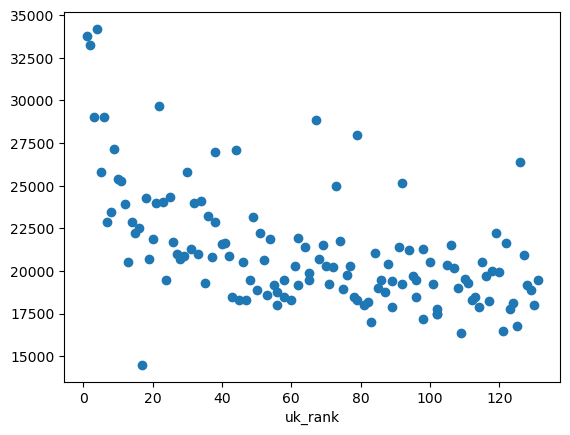

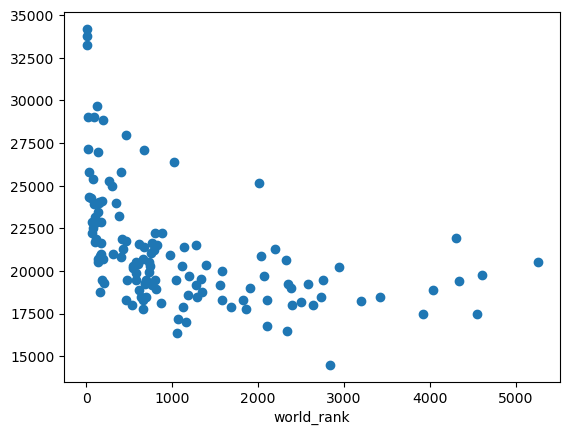

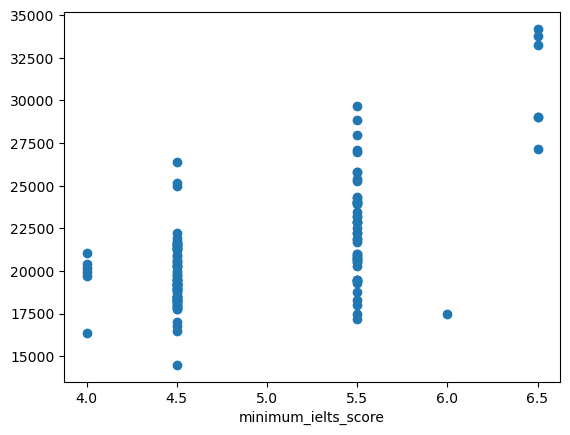

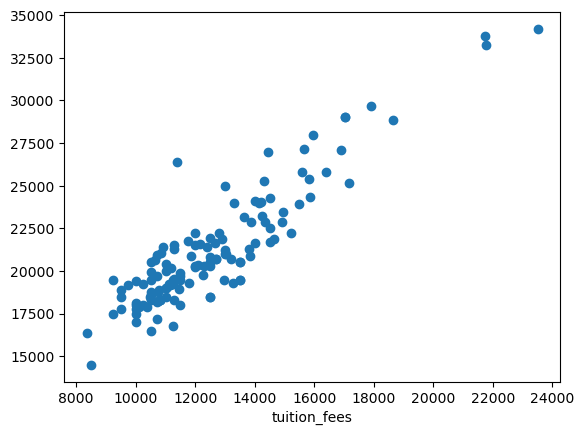

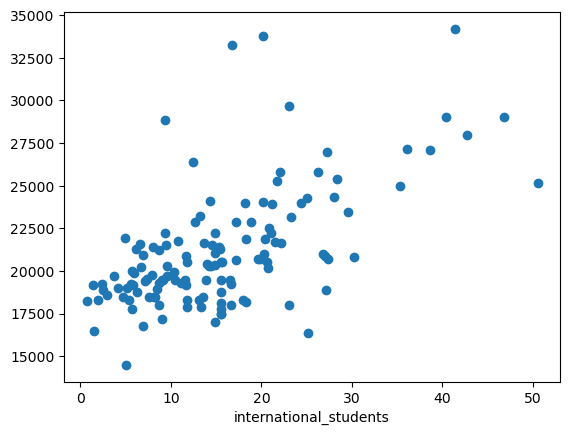

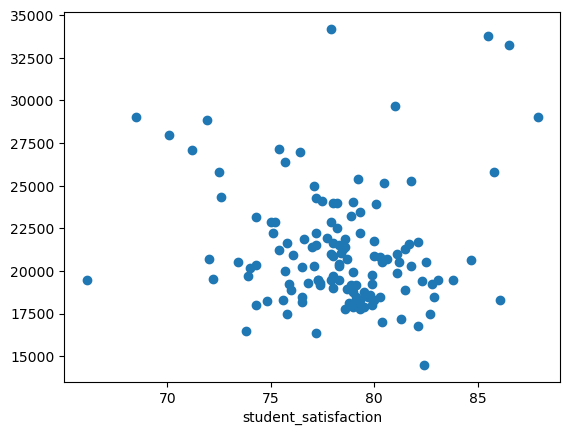

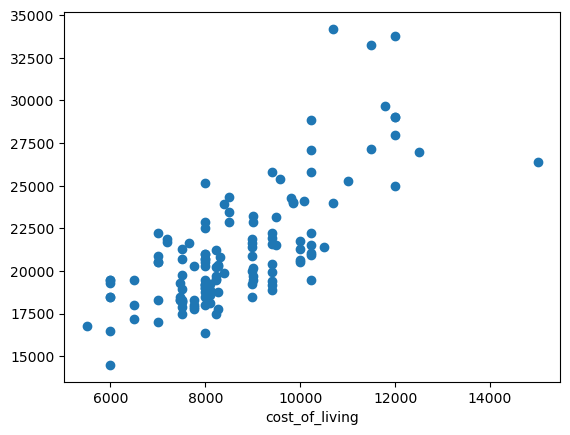

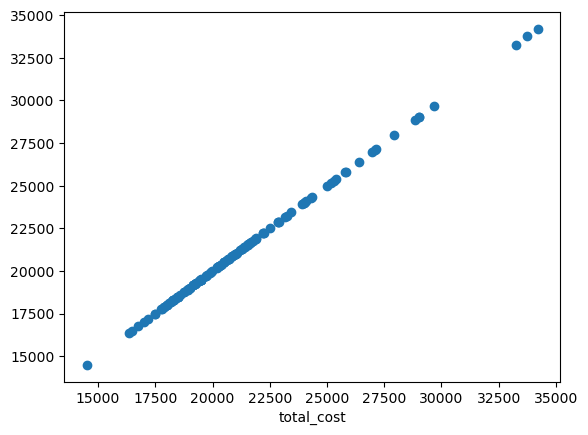

In [45]:
# pemanggilan fungsi scatters untuk melihat korelasi antara data numerik dengan target = total cost

scatters(data_numerik,data_numerik['total_cost'])

In [46]:
# cek hubungan linear dengan total cost
linear_test(data_numerik,data_numerik['total_cost'])

There are 8 variables which are linearly related based on Pearson testing result.
founded_year, uk_rank, world_rank, minimum_ielts_score, tuition_fees, international_students, cost_of_living, total_cost


#### **INSIGHT:**
- Berdasarkan hasil scatter plot, ditemukan korelasi negatif dengan total_cost untuk kolom founded_year, uk_rank, dan world_rank.
- ternyata semua kolom yang berada dalam data_numerik (kecuali total_cost tidak dianggap) memiliki hubungan linear dengan total_cost karena lulus Pearson Test.

### <u>ASUMSI KEDUA: MULTIKOLINEARITAS</u>

- syarat : tidak ada hubungan multikolinearitas yang signifikan antara variable non-target (bukan total_cost).

- metode : menggunakan Variance Inflation Factor (VIF) value (VIF < 10)

In [47]:
# Fungsi unutk mengukur Variance Inflation Factor (VIF value)

def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [112]:
# hilangkan target pada data untuk dites kolinearitasnya
data_numerik1 = data_numerik.drop(['total_cost'],axis = 1)
# panggil fungsi
calculate_vif(data_numerik1)

,variables,VIF
0,founded_year,161.122949
1,uk_rank,8.857832
2,world_rank,3.046372
3,minimum_ielts_score,132.224712
4,tuition_fees,72.458466
5,international_students,6.611122
6,student_satisfaction,254.411092
7,cost_of_living,40.216760


In [113]:
# hilangkan data dengan VIF tertinggi
data_numerik2 = data_numerik1.drop(['student_satisfaction'],axis = 1)

# panggil fungsi
calculate_vif(data_numerik2)

,variables,VIF
0,founded_year,74.215498
1,uk_rank,8.856601
2,world_rank,2.984992
3,minimum_ielts_score,111.787403
4,tuition_fees,67.770319
5,international_students,6.050971
6,cost_of_living,39.964518


In [114]:
# hilangkan data dengan VIF tertinggi
data_numerik3 = data_numerik2.drop(['minimum_ielts_score'],axis = 1)

# panggil fungsi
calculate_vif(data_numerik3)

,variables,VIF
0,founded_year,49.024187
1,uk_rank,8.301558
2,world_rank,2.880123
3,tuition_fees,46.390719
4,international_students,5.962077
5,cost_of_living,38.720133


In [115]:
# hilangkan data dengan VIF tertinggi
data_numerik4 = data_numerik3.drop(['founded_year'],axis = 1)

# panggil fungsi
calculate_vif(data_numerik4)

,variables,VIF
0,uk_rank,5.855172
1,world_rank,2.782420
2,tuition_fees,29.185767
3,international_students,5.897018
4,cost_of_living,36.505514


In [116]:
# hilangkan data dengan VIF tertinggi
data_numerik5 = data_numerik4.drop(['cost_of_living'],axis = 1)

# panggil fungsi
calculate_vif(data_numerik5)

,variables,VIF
0,uk_rank,4.443528
1,world_rank,2.763550
2,tuition_fees,8.900086
3,international_students,5.707506


#### **INSIGHT:**

- Setelah melakukan screening dengan penghitungan VIF value, telah ditetapkan 4 variabel: uk_rank, world_rank, tuition_fees, dan international_students sebagai fitur untuk pemodelan regresi linear. Keempat variabel memenuhi asumsi tentang kolinearitas rendah.


# **5. FEATURE ENGINEERING**

## i. **Feature Creation**

- Handling cardinality, outlier, missing values.
- Spliting dataset.

### <u>Handling Cardinality</u>

1. Cek unique values untuk setiap kolom pada data_kategorik.

2. Kolom baru akan dibuat untuk menyimpan data secara lengkap.

In [99]:
# memanggil fungsi untuk melihat data unik
def cek_data_unik(data):
    cols = data.columns.tolist()
    # melakukan iterasi untuk scatter plot tiap nama kolom vs kolom price
    for i in range (len(cols)):
        print(f'Data unik {cols[i]} berjumlah: {len(data[cols[i]].unique())}')
        print(data[cols[i]].unique())

In [100]:
# memanggil fungsi
cek_data_unik(data_kategorik)

Data unik region berjumlah: 12
['Wales' 'London' 'South West England' 'East of England' 'Scotland'
 'West Midlands' 'South East England' 'North West England' 'East Midlands'
 'Northern Ireland' 'Yorkshire and the Humber' 'North East England']
Data unik student_enrollment berjumlah: 16
['20,000-24,999' '15,000-19,999' '10,000-14,999' '8,000-8,999'
 '5,000-5,999' '2,000-2,999' '25,000-29,999' '1,000-1,999' '30,000-34,999'
 '9,000-9,999' '7,000-7,999' '6,000-6,999' '40,000-44,999' '4,000-4,999'
 '3,000-3,999' '35,000-39,999']
Data unik academic_staff berjumlah: 18
['1,000-1,499' '4,000-4,499' '700-799' '600-699' '900-999' '100-199'
 '2,000-2,499' '1,500-1,999' '300-399' '3,000-3,499' '400-499'
 '2,500-2,999' '50-99' '500-599' 'over-5,000' '200-299' '800-899'
 '3,500-3,999']
Data unik type berjumlah: 2
['Public' 'Private']
Data unik location berjumlah: 4
['Suburban' 'Urban' 'Rural' nan]


### **INSIGHT:**
- Ditemukan 12 data unik pada region yang bisa dikelompokkan menjadi 4: England, Scotland, Wales, dan Ireland.
- Data unik student_enrollment adalah 16 sedangkan data unik academic_staff adalah 18. Kedua variabel ini memiliki kardinalitas yang sangat tinggi dibanding yang lain.
- Kemudian data unik untuk type adalah 2.
- Lalu, data unik location adalah 4. Karena keterbatasan waktu, location tidak akan digunakan.

Sumber:

https://en.wikipedia.org/wiki/Countries_of_the_United_Kingdom

In [110]:
def region_reduction(data):
    new_reg = ['England', 'Scotland', 'Wales', 'Ireland']
    # initiate new column
    data.insert(1,'new_region','no values')
    data.loc[data['region'].str.contains('England') |data['region'].str.contains('London') | data['region'].str.contains('Midlands')| data['region'].str.contains('Yorkshire and the Humber'), 'new_region'] = new_reg[0]
    data.loc[data['region'].str.contains('Scotland'), 'new_region'] = new_reg[1]
    data.loc[data['region'].str.contains('Wales'), 'new_region'] = new_reg[2]
    data.loc[data['region'].str.contains('Ireland'), 'new_region'] = new_reg[3]

In [111]:
region_reduction(data_kategorik)

data_kategorik

,region,new_region,student_enrollment,academic_staff,type,location
0,Wales,Wales,"20,000-24,999","1,000-1,499",Public,Suburban
1,London,England,"15,000-19,999","4,000-4,499",Public,Urban
2,Wales,Wales,"10,000-14,999",700-799,Public,Urban
3,South West England,England,"8,000-8,999",600-699,Public,Suburban
4,East of England,England,"20,000-24,999",900-999,Public,Urban
...,...,...,...,...,...,...
126,Yorkshire and the Humber,England,"15,000-19,999","1,000-1,499",Public,Suburban
127,South West England,England,"7,000-7,999",600-699,Public,Rural
128,South East England,England,"15,000-19,999","1,000-1,499",Public,Suburban
129,East Midlands,England,"15,000-19,999","1,500-1,999",Public,Suburban


### <u>Splitting dataset</u>

In [117]:
# melakukan reset index bagi data_kategorik dan data_numerik untuk menghilangkan kemungkinan missing values
data_kategorik.reset_index(drop=True, inplace=True)
data_numerik5.reset_index(drop=True, inplace=True)
# penggabungan fitur-fitur relevan dalam satu dataframe dengan concat
kombinasi_df = pd.concat([data_numerik5,data_kategorik['type'],data_kategorik['new_region']],axis=1)

# menunjukkan kombinasi_df
kombinasi_df

,uk_rank,world_rank,tuition_fees,international_students,type,new_region
0,31,422,13800,15.4,Public,Wales
1,4,8,23500,41.4,Public,England
2,112,1821,10800,18.0,Public,Wales
3,95,2073,11500,3.7,Public,England
4,120,730,10500,10.4,Public,England
...,...,...,...,...,...,...
126,77,734,12300,9.6,Public,England
127,110,1334,11300,7.4,Public,England
128,32,342,13300,24.4,Public,England
129,41,167,14000,22.2,Public,England


In [119]:
# sebut saja semua fitur yang tersimpan dalam combined_df sebagai X
X = kombinasi_df

# definisikan target (y)
y = main_data['total_cost']

In [120]:
# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train size : ', X_train.shape)
print('Test size  : ', X_test.shape)

Train size :  (104, 6)
Test size  :  (27, 6)


In [121]:
# Tanpa kolom uk_rank: karena kolom uk_rank dan world_rank lumayan mirip konteks datanya
X_train_no_uk_rank = X_train.drop('uk_rank', axis=1)
X_test_no_uk_rank = X_test.drop('uk_rank', axis=1)

# Keep y_train and test as it is
y_train_no_uk_rank = y_train
y_test_no_uk_rank = y_test

# cek size
print('Train size : ', X_train_no_uk_rank.shape)
print('Test size : ', X_test_no_uk_rank.shape)

Train size :  (104, 5)
Test size :  (27, 5)


In [122]:
X_train

,uk_rank,world_rank,tuition_fees,international_students,type,new_region
78,111,680,11795,11.10,Public,England
47,126,1025,11400,12.40,Public,England
0,31,422,13800,15.40,Public,Wales
12,47,659,11275,11.80,Public,Scotland
42,45,466,10500,13.10,Public,Wales
...,...,...,...,...,...,...
71,89,1682,10380,13.30,Public,England
106,124,864,10000,15.59,Public,England
14,54,416,12890,20.40,Public,England
92,131,2759,9250,15.59,Public,England


In [123]:
X_train_no_uk_rank

,world_rank,tuition_fees,international_students,type,new_region
78,680,11795,11.10,Public,England
47,1025,11400,12.40,Public,England
0,422,13800,15.40,Public,Wales
12,659,11275,11.80,Public,Scotland
42,466,10500,13.10,Public,Wales
...,...,...,...,...,...
71,1682,10380,13.30,Public,England
106,864,10000,15.59,Public,England
14,416,12890,20.40,Public,England
92,2759,9250,15.59,Public,England


## ii. **Feature Extraction, Transformation, dan Selection**
- Encoding, Feature Scaling, Feature Selection

In [124]:
def nan_counter(data_name):
    # cek jumlah data null
# menghitung jumlah data NaN
    nan_counts_per_column = data_name.isna().sum()

    #  Menunjukkan semua data yang memiliki NaN
    for column, nan_count in nan_counts_per_column.items():
        print(f"Kolom '{column}' memiliki {nan_count} NaN values.")

In [125]:
# Memanggil class onehotencoder
one_hot_encode = OneHotEncoder(sparse=False)

# Fit and transform data training
one_hot_features_train = one_hot_encode.fit_transform(X_train[['type', 'new_region']])

# Transform the test data
one_hot_features_test = one_hot_encode.transform(X_test[['type', 'new_region']])

# Transform the data training yang tidak ada kolom uk_rank
one_hot_features_no_uk_rank = one_hot_encode.transform(X_train_no_uk_rank[['type', 'new_region']])



# Mendapatkan nama-nama fitur
feature_names = one_hot_encode.get_feature_names_out(['type', 'new_region'])

# Membuat dataframe baru
X_train_encoded = pd.concat([X_train.drop(['type', 'new_region'], axis=1).reset_index(drop=True),
                             pd.DataFrame(one_hot_features_train, columns=feature_names)],
                            axis=1)

X_test_encoded = pd.concat([X_test.drop(['type', 'new_region'], axis=1).reset_index(drop=True),
                            pd.DataFrame(one_hot_features_test, columns=feature_names)],
                           axis=1)

X_train_no_uk_rank_encoded = pd.concat([X_train_no_uk_rank.drop(['type', 'new_region'], axis=1).reset_index(drop=True),
                                     pd.DataFrame(one_hot_features_no_uk_rank , columns=feature_names)],
                                    axis=1)


/Users/catherinemulyadi/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [126]:
# cek jumlah data nan di dataset X_train_encoded
nan_counter(X_train_encoded)

Kolom 'uk_rank' memiliki 0 NaN values.
Kolom 'world_rank' memiliki 0 NaN values.
Kolom 'tuition_fees' memiliki 0 NaN values.
Kolom 'international_students' memiliki 0 NaN values.
Kolom 'type_Private' memiliki 0 NaN values.
Kolom 'type_Public' memiliki 0 NaN values.
Kolom 'new_region_England' memiliki 0 NaN values.
Kolom 'new_region_Ireland' memiliki 0 NaN values.
Kolom 'new_region_Scotland' memiliki 0 NaN values.
Kolom 'new_region_Wales' memiliki 0 NaN values.


In [127]:
# cek jumlah data nan di dataset X_test_encoded
nan_counter(X_test_encoded)

Kolom 'uk_rank' memiliki 0 NaN values.
Kolom 'world_rank' memiliki 0 NaN values.
Kolom 'tuition_fees' memiliki 0 NaN values.
Kolom 'international_students' memiliki 0 NaN values.
Kolom 'type_Private' memiliki 0 NaN values.
Kolom 'type_Public' memiliki 0 NaN values.
Kolom 'new_region_England' memiliki 0 NaN values.
Kolom 'new_region_Ireland' memiliki 0 NaN values.
Kolom 'new_region_Scotland' memiliki 0 NaN values.
Kolom 'new_region_Wales' memiliki 0 NaN values.


In [128]:
# cek jumlah data nan di dataset X_train_no_uk_rank_encoded
nan_counter(X_train_no_uk_rank_encoded)

Kolom 'world_rank' memiliki 0 NaN values.
Kolom 'tuition_fees' memiliki 0 NaN values.
Kolom 'international_students' memiliki 0 NaN values.
Kolom 'type_Private' memiliki 0 NaN values.
Kolom 'type_Public' memiliki 0 NaN values.
Kolom 'new_region_England' memiliki 0 NaN values.
Kolom 'new_region_Ireland' memiliki 0 NaN values.
Kolom 'new_region_Scotland' memiliki 0 NaN values.
Kolom 'new_region_Wales' memiliki 0 NaN values.


In [142]:
def std_scaler(data):
    kolom_data_numerik = ['world_rank','tuition_fees','international_students','uk_rank']
    data_numerik_scaled = data[kolom_data_numerik]
    # memanggil class StandardScaler
    scaler = StandardScaler()

    # Fit and transform the selected columns
    hasil_scaling = scaler.fit_transform(data_numerik_scaled)

    # Create a new DataFrame with the scaled values
    hasil_scaling_df = pd.DataFrame(hasil_scaling, columns=kolom_data_numerik).reset_index(drop = True)

    return hasil_scaling_df

In [143]:
def std_scaler2(data):
    kolom_data_numerik = ['world_rank','tuition_fees','international_students']
    data_numerik_scaled = data[kolom_data_numerik]
    # memanggil class StandardScaler
    scaler = StandardScaler()

    # Fit and transform the selected columns
    hasil_scaling = scaler.fit_transform(data_numerik_scaled)

    # Create a new DataFrame with the scaled values
    hasil_scaling_df = pd.DataFrame(hasil_scaling, columns=kolom_data_numerik).reset_index(drop = True)

    return hasil_scaling_df

In [144]:
# implementasi fungsi dengan standard scaler

X_train_scaled_data = std_scaler(X_train_encoded)

X_test_scaled_data = std_scaler(X_test_encoded)

X_train_nouk_scaled_data = std_scaler2(X_train_no_uk_rank_encoded)

In [146]:
def replace_val(data,new_data):
    final_data = data.copy()
    final_data['world_rank'] = new_data['world_rank']
    final_data['tuition_fees'] = new_data['tuition_fees']
    final_data['international_students'] = new_data['international_students']
    return final_data

In [147]:
def replace_val2(data,new_data):
    final_data = data.copy()
    final_data['world_rank'] = new_data['world_rank']
    final_data['tuition_fees'] = new_data['tuition_fees']
    final_data['international_students'] = new_data['international_students']
    final_data['uk_rank'] = new_data['uk_rank']
    return final_data

In [148]:
# implementasi replace values

X_train_final = replace_val2(X_train_encoded,X_train_scaled_data)
X_test_final = replace_val2(X_test_encoded,X_test_scaled_data)
X_train_nouk_scaled_data_final = replace_val(X_train_no_uk_rank_encoded,X_train_nouk_scaled_data)


In [149]:
X_train_final

,uk_rank,world_rank,tuition_fees,international_students,type_Private,type_Public,new_region_England,new_region_Ireland,new_region_Scotland,new_region_Wales
0,1.216978,-0.342821,-0.309872,-0.545848,0.0,1.0,1.0,0.0,0.0,0.0
1,1.612496,-0.027950,-0.457917,-0.408482,0.0,1.0,1.0,0.0,0.0,0.0
2,-0.892450,-0.578290,0.441599,-0.091483,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.470565,-0.361987,-0.504767,-0.471881,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.523300,-0.538132,-0.795236,-0.334515,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
99,0.636885,0.571673,-0.840211,-0.313382,0.0,1.0,1.0,0.0,0.0,0.0
100,1.559760,-0.174890,-0.982635,-0.071406,0.0,1.0,1.0,0.0,0.0,0.0
101,-0.285990,-0.583766,0.100532,0.436849,0.0,1.0,1.0,0.0,0.0,0.0
102,1.744335,1.554617,-1.263734,-0.071406,0.0,1.0,1.0,0.0,0.0,0.0


In [150]:
X_test_final

,uk_rank,world_rank,tuition_fees,international_students,type_Private,type_Public,new_region_England,new_region_Ireland,new_region_Scotland,new_region_Wales
0,0.705194,0.019231,-0.885569,-0.490190,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.161502,-0.454913,0.095033,0.231781,0.0,1.0,1.0,0.0,0.0,0.0
2,-1.732389,-0.960925,2.448885,3.390406,0.0,1.0,1.0,0.0,0.0,0.0
3,-0.946946,-0.823346,0.541453,-0.430026,0.0,1.0,0.0,1.0,0.0,0.0
4,0.163509,2.602924,0.018939,-0.510245,1.0,0.0,1.0,0.0,0.0,0.0
5,-1.569884,-0.906515,1.667650,0.823397,0.0,1.0,1.0,0.0,0.0,0.0
6,-1.136536,-0.826455,0.237076,0.662958,0.0,1.0,1.0,0.0,0.0,0.0
7,-0.215671,2.363521,0.145763,-0.811067,0.0,1.0,1.0,0.0,0.0,0.0
8,1.598974,2.153654,-1.378660,-1.051724,0.0,1.0,1.0,0.0,0.0,0.0
9,-0.513598,-0.297124,0.297952,-0.359834,0.0,1.0,1.0,0.0,0.0,0.0


In [151]:
X_train_nouk_scaled_data_final

,world_rank,tuition_fees,international_students,type_Private,type_Public,new_region_England,new_region_Ireland,new_region_Scotland,new_region_Wales
0,-0.342821,-0.309872,-0.545848,0.0,1.0,1.0,0.0,0.0,0.0
1,-0.027950,-0.457917,-0.408482,0.0,1.0,1.0,0.0,0.0,0.0
2,-0.578290,0.441599,-0.091483,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.361987,-0.504767,-0.471881,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.538132,-0.795236,-0.334515,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
99,0.571673,-0.840211,-0.313382,0.0,1.0,1.0,0.0,0.0,0.0
100,-0.174890,-0.982635,-0.071406,0.0,1.0,1.0,0.0,0.0,0.0
101,-0.583766,0.100532,0.436849,0.0,1.0,1.0,0.0,0.0,0.0
102,1.554617,-1.263734,-0.071406,0.0,1.0,1.0,0.0,0.0,0.0


# **6. MODEL DEFINITION**

Notes :  

1. Algoritma yang dipakai adalah <u>Linear Regression</u>
   * Alasan : Karena target data yang akan diprediksi bernilai continuous yaitu total cost.

2. Metrics yang akan dipakai adalah <u>Mean Absolute Error (MAE)</u>
   * Alasan : Karena mudah untuk dipahami dan data numerik memiliki persentase outlier tidak signifikan (< 5%).

3. Metrics lain yang akan dipakai adalah <u>R2 - score</u>
* Alasan : Untuk melihat performa model regresi linear berdasarkan kemampuan prediksi variance pada target (y = price)

# **7. MODEL TRAINING**

- Mencari intercept dan slope.

### <u>Model 1: fitur pada X_train paling lengkap </u>

In [152]:
# Training using Linear Regression untuk X_train_final dan y_train

model_linreg = LinearRegression()
model_linreg.fit(X_train_final, y_train)

LinearRegression()

In [153]:
# Melakukan pengecekan koefisien dan intercept

coefficients = model_linreg.coef_
intercept = model_linreg.intercept_

params = {
    'feature': X_train_final.columns.tolist(),
    'coefficient': model_linreg.coef_.tolist()
}

print('Intercept : ', intercept)
pd.DataFrame(params)

Intercept :  19472.78294547573


,feature,coefficient
0,uk_rank,446.164750
1,world_rank,8.881422
2,tuition_fees,3330.038927
3,international_students,425.430500
4,type_Private,-1063.403743
5,type_Public,1063.403743
6,new_region_England,1028.199017
7,new_region_Ireland,-1436.422365
8,new_region_Scotland,193.829137
9,new_region_Wales,214.394210


### <u>Model 2: tanpa fitur uk_rank </u>

In [154]:
# Training using Linear Regression untuk X_train_trimmed_final dan y_train_trimmed

model_linreg2 = LinearRegression()
model_linreg2.fit(X_train_nouk_scaled_data_final, y_train_no_uk_rank)

LinearRegression()

In [156]:
# Melakukan pengecekan koefisien dan intercept

coefficients = model_linreg2.coef_
intercept2 = model_linreg2.intercept_

params2 = {
    'feature': X_train_nouk_scaled_data_final.columns.tolist(),
    'coefficient': model_linreg2.coef_.tolist()
}

print('Intercept : ', intercept2)
pd.DataFrame(params2)

Intercept :  19554.82080536939


,feature,coefficient
0,world_rank,95.133425
1,tuition_fees,3084.709361
2,international_students,413.422414
3,type_Private,-919.969122
4,type_Public,919.969122
5,new_region_England,1106.003932
6,new_region_Ireland,-1444.267013
7,new_region_Scotland,174.140013
8,new_region_Wales,164.123067


### **INSIGHT UNTUK SLOPE DAN INTERCEPT:**
- Nilai slope (koefisien) dan intercept untuk setiap fitur berhasil dihitung pada semua model.

- Nilai slope menyatakan faktor pengubahan pada nilai target untuk setiap peningkatan nilai pada fitur. Misalkan, bila fitur world_rank memiliki slope = 95, maka setiap penambahan fitur world_rank mengakibatkan setiap unit peningkatan  pada target (total_cost) sebesar 95.

- Nilai intercept adalah nilai yang didapat bila semua fitur adalah 0. Berdasarkan hasil penghitungan, semua model memiliki nilai intercept positif yang dianggap sebagai baseline total cost. Baseline total cost adalah nilai awal yang digunakan model untuk membuat prediksi harga berdasarkan fitur yang ada.

# **8. MODEL EVALUATION**

- Menggunakan metrics evaluasi: MAE, MSE, RMSE, dan R2 - score

### MODEL 1:

In [157]:
# Prediksi Train-Set and Test-Set dengan ori data

y_pred_train = model_linreg.predict(X_train_final)
y_pred_test = model_linreg.predict(X_test_final)

In [158]:
def model_metrics(y_pred_train,y_pred_test,y_train,y_test):
    print('Train Set - MAE : ', mean_absolute_error(y_train, y_pred_train))
    print('Test Set - MAE  : ', mean_absolute_error(y_test, y_pred_test))
    print('')

    print('Train Set Model 1- MSE  : ', mean_squared_error(y_train, y_pred_train))
    print(' Test Set - MSE : ', mean_squared_error(y_test, y_pred_test))
    print('')

    print('Train Set - RMSE : ', mean_squared_error(y_train, y_pred_train, squared=False))
    print('Test Set - RMSE : ', mean_squared_error(y_test, y_pred_test, squared=False))
    print('')

    print('R2 Score - Train Set - R2 Score : ', r2_score(y_train, y_pred_train))
    print('Test Set - R2 Score : ', r2_score(y_test, y_pred_test))
    print('')

In [159]:
print('Hasil Modelling Regresi Linear 1')
model_metrics(y_pred_train,y_pred_test,y_train,y_test)

Hasil Modelling Regresi Linear 1
Train Set - MAE :  1039.3487385189212
Test Set - MAE  :  1254.6438915905094

Train Set Model 1- MSE  :  1869306.936874797
 Test Set - MSE :  2627032.203831312

Train Set - RMSE :  1367.2260006578272
Test Set - RMSE :  1620.8122049859176

R2 Score - Train Set - R2 Score :  0.8569518390953071
Test Set - R2 Score :  0.649931302555727



### MODEL 2:

In [163]:
# Prediksi Train-Set and Test-Set dengan trimmed data
X_test_no_rank_final = X_test_final.drop('uk_rank',axis = 1)
y_pred_train2 = model_linreg2.predict(X_train_nouk_scaled_data_final)
y_pred_test2 = model_linreg2.predict(X_test_no_rank_final)

In [164]:
print('Hasil Modelling Regresi Linear 2')
model_metrics(y_pred_train2,y_pred_test2,y_train_no_uk_rank,y_test)

Hasil Modelling Regresi Linear 2
Train Set - MAE :  1069.4571328609977
Test Set - MAE  :  1252.4167433748996

Train Set Model 1- MSE  :  1970656.842417274
 Test Set - MSE :  2555291.481372695

Train Set - RMSE :  1403.8008556833388
Test Set - RMSE :  1598.5279107268334

R2 Score - Train Set - R2 Score :  0.8491960675257895
Test Set - R2 Score :  0.6594912086840843



# **9. MODEL SAVING**

In [167]:
# Memisahkan nama kolom data kategorik dan numerik
column_names_list = kombinasi_df.columns.tolist()
column_names_list
num_columns = column_names_list[0:4]
cat_columns = column_names_list[4:]

In [168]:
# Menyimpan file berkaitan dengan model regresi linear

with open('model_linreg.pkl', 'wb') as file_1:
  pickle.dump(model_linreg, file_1)

with open('model_scaler.pkl', 'wb') as file_2:
  pickle.dump(std_scaler, file_2)

with open('model_ohe_encoder_1.pkl', 'wb') as file_3:
  pickle.dump(one_hot_encode, file_3)

with open('list_num_cols.txt', 'w') as file_4:
  json.dump(num_columns, file_4)

with open('list_cat_cols.txt','w') as file_5:
  json.dump(cat_columns, file_5)

# **10. MODEL INFERENCE**

- Menyiapkan data baru untuk tes performa model.

In [169]:
kombinasi_df.columns.tolist()

['uk_rank',
 'world_rank',
 'tuition_fees',
 'international_students',
 'type',
 'new_region']

In [172]:
inference_data = {'uk_rank':[28,52],'world_rank':[3458,4957], 'tuition_fees':[10000,9500],'international_students':[521,422],'type':['Public','Private'],'new_region':['Ireland','Scotland'],'total_cost':[13000,11000]}

inference_df = pd.DataFrame(inference_data)

inference_df

,uk_rank,world_rank,tuition_fees,international_students,type,new_region,total_cost
0,28,3458,10000,521,Public,Ireland,13000
1,52,4957,9500,422,Private,Scotland,11000


In [173]:
# melakukan splitting dataset
# sebut saja semua fitur yang tersimpan dalam combined_df sebagai X
X_inf= inference_df.drop('total_cost',axis = 1)

# definisikan target (y)
y_inf = inference_df['total_cost']

In [175]:

# Transform the data training yang tidak ada kolom uk_rank
one_hot_features_inf = one_hot_encode.transform(X_inf[['type', 'new_region']])



# Mendapatkan nama-nama fitur
feature_names = one_hot_encode.get_feature_names_out(['type', 'new_region'])

# Membuat dataframe baru
X_inf_encoded = pd.concat([X_train.drop(['type', 'new_region'], axis=1).reset_index(drop=True),
                             pd.DataFrame(one_hot_features_train, columns=feature_names)],
                            axis=1)


In [178]:
X_inf_scaled_data = std_scaler(X_inf_encoded)
X_inf_train_final = replace_val2(X_inf_encoded,X_inf_scaled_data)

In [179]:
# Prediksi Train-Set and Test-Set dengan ori data

y_pred_train = model_linreg.predict(X_inf_train_final)
y_pred_test = model_linreg.predict(X_test_final)

# **11. CONCLUSION**
- Kesimpulan EDA, Evaluasi Model, Analysis Model, Ide Peningkatan Model
- Untuk EDA:
    - Berdasarkan hasil grouping dan visualisasi dengan bar chart, ditemukan bahwa liga dengan jumlah universitas terbanyak adalah League C pada 33 universitas, diikuti League B pada 32 universitas, League D di 23 universitas, League E di 21 universitas, dan League F di 6 universitas.
    - Untuk hubungan antara world rank, type, dan tuition fees, ANOVA test menyebutkan ada hubungan signifikan karena P-value: 1.839634471361231e-220. 
- Evaluasi Model:
    - Ternyata modelnya memiliki perbedaan R2 - score signifikan antara train set dan test set (sekitar 20%). Artinya, modelnya tidak konsisten. Jadi, model dapat memprediksi variasi total biaya pengeluaran (total_cost) bila studi di UK sebesar 65%.
    - Bila kolom uk_rank dihapus, MAEnya lebih besar daripada tidak. Sehingga, model 1 (dengan variabel lebih lengkap) memiliki performa lebih baik.

- Peningkatan model:
    - Sebaiknya menambah fitur lain yang belum diencode supaya bisa merepresentasikan prediksi total cost lebih baik.
    - Handling outlier untuk data-data numerik.
    - Menggunakan model lain yang tidak tergantung pada hubungan linear seperti polynomial regression.